# Classification (Titanic dataset)
***
## Set up

In [1]:
import os
import datetime
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection, metrics
import copy

from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder

In [2]:
local_path = 'data/classification/'

path = local_path

# For test train files
train = pd.read_csv(path+'train.csv',  index_col=0)
test = pd.read_csv(path+'test.csv',  index_col=0)

# Setting target
target = 'Survived'

In [3]:
train.head(30)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [4]:
# Mem reduction function by converting data types. (Credit to Guillaume Martin and Arjan Groen)
# I would like to make this check floats better and extend to catagory for objects that fit, and bools.

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if (c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return

reduce_mem_usage(train)
reduce_mem_usage(test)

Mem. usage decreased to  0.05 Mb (41.7% reduction)
Mem. usage decreased to  0.02 Mb (37.5% reduction)


***
## Feature engingeering

Only feature engineering that can be safely done before test train split

In [5]:
from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
out = detect_outliers(train, 2, ['Fare', 'SibSp', 'Parch', 'Age'])
out

[28, 89, 160, 181, 202, 325, 342, 793, 847, 864]

In [6]:
# Adding features

train.drop(out, axis = 0, inplace = True)

In [7]:
# Deck feature from Cabin

train['Deck'] = train['Cabin'].str.extract('(\w)')
train['Deck'] = train['Deck'].replace({'T': 0, 'A': 1, 'B': 2, 'C' :3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}, regex=True)
train['Deck'] = train['Deck'].fillna(8)

test['Deck'] = test['Cabin'].str.extract('(\w)')
test['Deck'] = test['Deck'].replace({'T': 0,'A': 1, 'B': 2, 'C' :3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}, regex=True)
test['Deck'] = test['Deck'].fillna(8)

In [8]:
# Family size

train['Family'] = train['SibSp'] + train['Parch']
test['Family'] = test['SibSp'] + test['Parch']

In [9]:
# Reducing title to four catagories (Master, Mr, Miss and Mrs)

train['Title'] = train.Name.str.extract(r'([A-Za-z]+)\.',expand=False)
test['Title'] = test.Name.str.extract(r'([A-Za-z]+)\.',expand=False)

In [10]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms', 'Dona']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [11]:
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)

In [12]:
# Getting medain age for each title catagory

full = pd.concat([test, train])
full.groupby('Title').Age.agg(['median'])

,median
Title,
Master,4.0
Miss,22.0
Mr,30.0
Mrs,36.0


In [13]:
missing_mask = train['Age'].isna()
mapping_dict = dict({'Master': 4, 'Miss': 22, 'Mr': 30, 'Mrs': 36})
train.loc[missing_mask, 'Age'] = train.loc[missing_mask, 'Title'].map(mapping_dict)
train['Age'] = train['Age'].fillna('Medium')

In [14]:
# Dropping

dropped = ['Name', 'Ticket', 'Cabin', 'Parch', 'Embarked', 'SibSp']
test = test.drop(dropped, axis=1)
train = train.drop(dropped, axis=1)

In [15]:
# Quick and dirty removing nans. Should proablay replace with mean, median (possibly mean of same sex or title)


#train = train[train['Age'].notna()]
#train = train[train['Embarked'].notna()]

# Fill with mean


In [16]:
train = train.fillna(train.median())
test = test.fillna(test.median())

/tmp/ipykernel_91203/1692775275.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train = train.fillna(train.median())
/tmp/ipykernel_91203/1692775275.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test = test.fillna(test.median())


In [17]:
# Labeling

enc = OrdinalEncoder()
encode = ['Sex', 'Title']
train[encode] = enc.fit_transform(train[encode])
test[encode] = enc.transform(test[encode])

In [18]:
train.groupby('Pclass').mean()['Survived']

Pclass
1    0.629108
2    0.472826
3    0.245868
Name: Survived, dtype: float64

In [19]:
# Dropping target
X = train.drop([target],axis=1)
y = train[target]

In [20]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [21]:
# Cleanlab check for noisy labels.

from cleanlab.latent_estimation import estimate_cv_predicted_probabilities
from cleanlab.pruning import get_noise_indices

from sklearn.neural_network import MLPClassifier

# Find the indices of label errors

X_train_data = np.array(X)
train_noisy_labels = np.array(y)

probabilities = estimate_cv_predicted_probabilities(
    X_train_data, 
    train_noisy_labels, 
    clf=MLPClassifier(),
)
label_error_indices = get_noise_indices(
    s = train_noisy_labels, 
    psx = probabilities, 
)

count = np.count_nonzero(label_error_indices)

print('No. of possible false labels: ', count)
print('Percent of possible false labels: ',count/X.shape[0])

ModuleNotFoundError: No module named 'cleanlab'

In [22]:
cols = X_train.columns
cols

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Deck', 'Family', 'Title'], dtype='object')

In [24]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])
#test[cols] = scaler.transform(test[cols])

In [25]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(n_jobs = -1)
X_train, y_train = sm.fit_resample(X_train, y_train)

ModuleNotFoundError: No module named 'imblearn'

In [26]:
X_train

,Pclass,Sex,Age,Fare,Deck,Family,Title
PassengerId,,,,,,,
228,0.0,0.0,-0.678571,-0.326314,0.0,0.0,0.0
206,0.0,-1.0,-2.000000,-0.180853,-1.0,1.0,-1.0
166,0.0,0.0,-1.500000,0.275349,0.0,2.0,-2.0
584,-2.0,0.0,0.428571,1.162980,-7.0,0.0,0.0
851,0.0,0.0,-1.857143,0.762343,0.0,6.0,-2.0
...,...,...,...,...,...,...,...
844,0.0,0.0,0.321429,-0.363122,0.0,0.0,0.0
197,0.0,0.0,0.000000,-0.303663,0.0,0.0,0.0
637,0.0,0.0,0.142857,-0.295700,0.0,0.0,0.0


***
# Modeling

In [31]:
# Importing all required models

from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier
import lightgbm as lgb

import scikitplot as skplt
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,roc_auc_score,roc_curve,confusion_matrix,classification_report, auc

In [32]:
# List of models to run through and compare

models = [
    ['CatBoostClassifier: ', CatBoostClassifier(verbose=False, per_float_feature_quantization='1:border_count=1024')],
    ['DecisionTreeClassifier: ', DecisionTreeClassifier()],
    ['RandomForestClassifier: ', RandomForestClassifier(n_estimators = 5000)],
    ['KNeighborsClassifier: ', KNeighborsClassifier()],
    ['ExtraTreesClassifier: ', ExtraTreesClassifier(min_samples_leaf=2, max_depth=9, n_estimators = 5000)],
    ['XGBClassifier: ', XGBClassifier(encoder=False)],
    ['MLPClassifier: ', MLPClassifier(max_iter=2000)],
    ['LogisticRegression: ', LogisticRegression()],
    ]

In [33]:
# Run for test train split. Quicker

def multimodel():
    for name,curr_model in models :
        print()
        print (name)
        curr_model.fit(X_train, y_train)
        print('Train score:', curr_model.score(X_train, y_train))
        print('Test score:', curr_model.score(X_test, y_test))
        
        y_pred = curr_model.predict(X_test)
        print(classification_report(y_test, y_pred))
        
        
        fig = plt.figure(figsize=(15,12))
        ax1 = fig.add_subplot(221)
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax=ax1)
        ax2 = fig.add_subplot(222)
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax2)

    
        y_probas = curr_model.predict_proba(X_test)
        ax3 = fig.add_subplot(223)
        skplt.metrics.plot_precision_recall(y_test, y_probas, ax=ax3)
        ax4 = fig.add_subplot(224)
        skplt.metrics.plot_roc(y_test, y_probas, ax=ax4)
        plt.tight_layout()
        try:
            skplt.estimators.plot_feature_importances(curr_model, feature_names=cols, x_tick_rotation = 90, max_num_features = 30)
            plt.show()
        except:
            print("No feature importances function in model")


CatBoostClassifier: 


/home/fraz/anaconda3/envs/mlenv/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Train score: 0.9019886363636364
Test score: 0.8587570621468926
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       105
           1       0.86      0.78      0.82        72

    accuracy                           0.86       177
   macro avg       0.86      0.85      0.85       177
weighted avg       0.86      0.86      0.86       177



/home/fraz/anaconda3/envs/mlenv/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


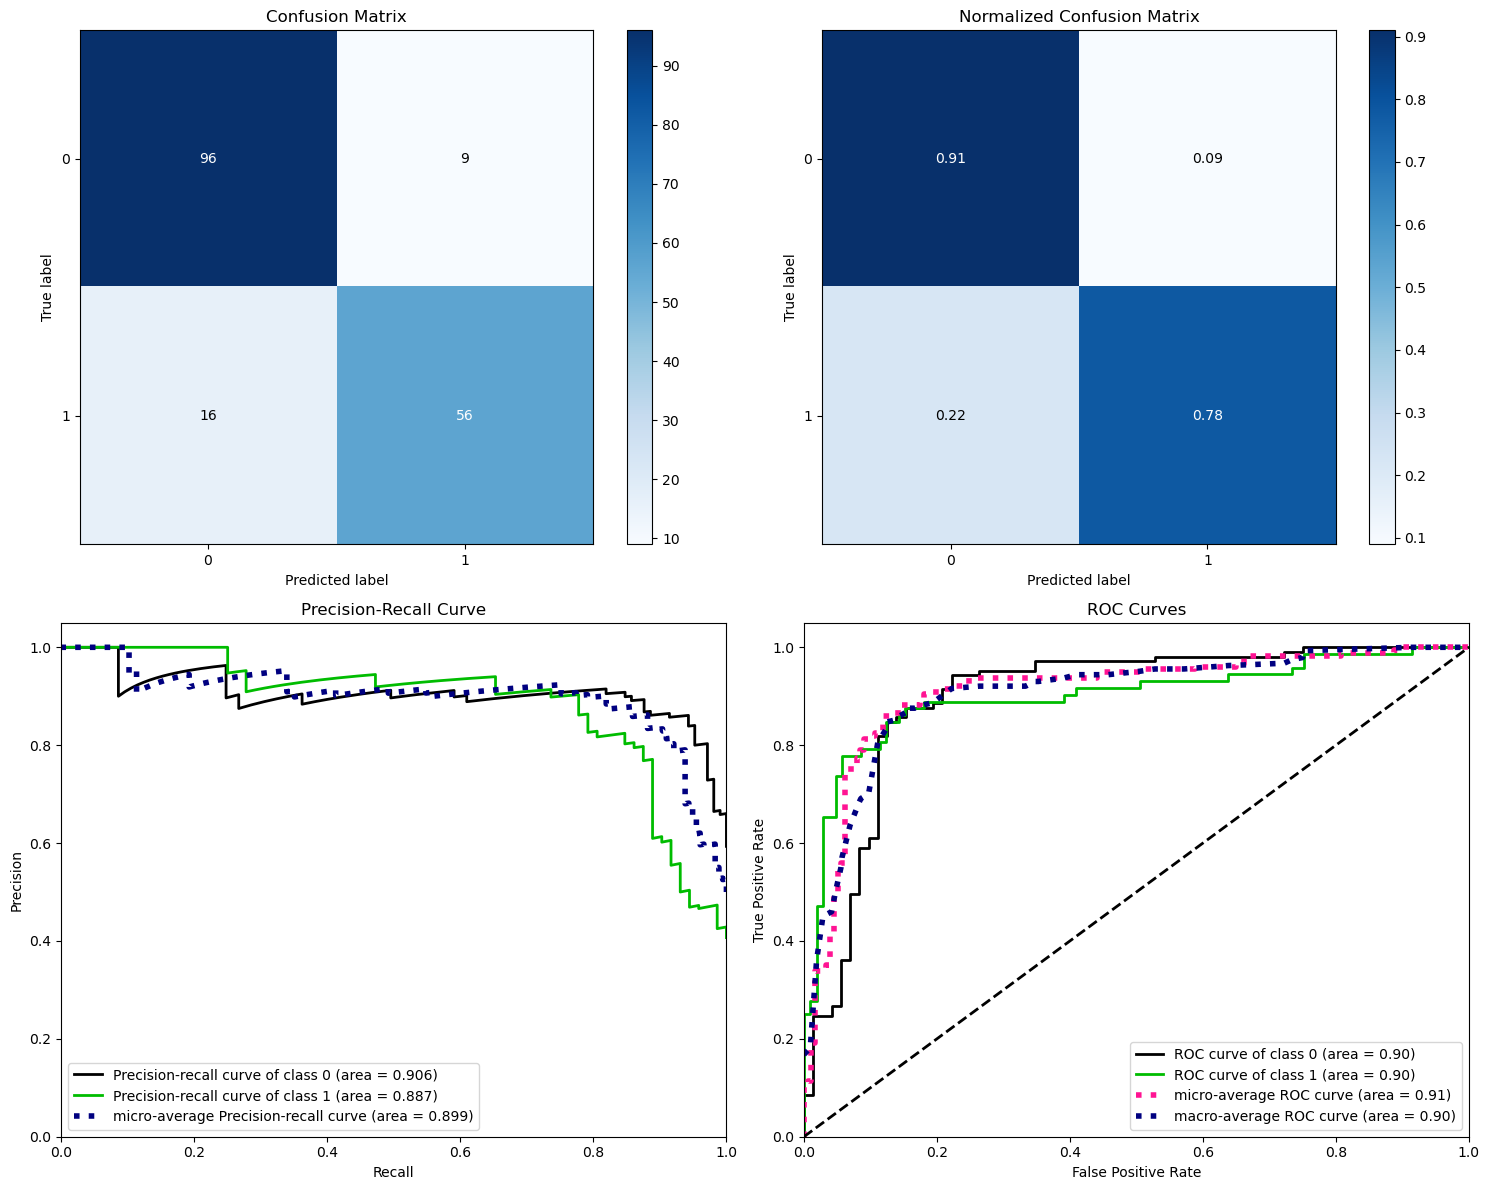

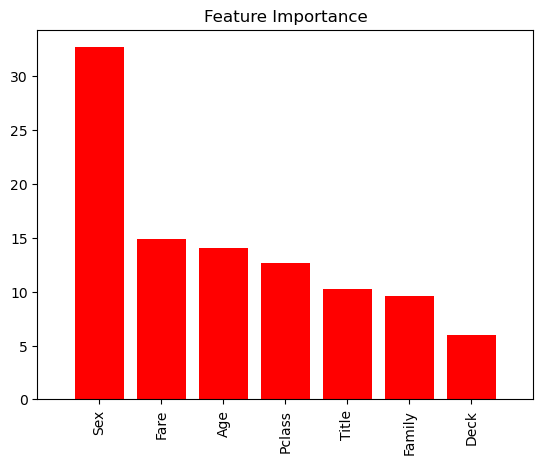


DecisionTreeClassifier: 
Train score: 0.9829545454545454
Test score: 0.8248587570621468
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       105
           1       0.79      0.78      0.78        72

    accuracy                           0.82       177
   macro avg       0.82      0.82      0.82       177
weighted avg       0.82      0.82      0.82       177



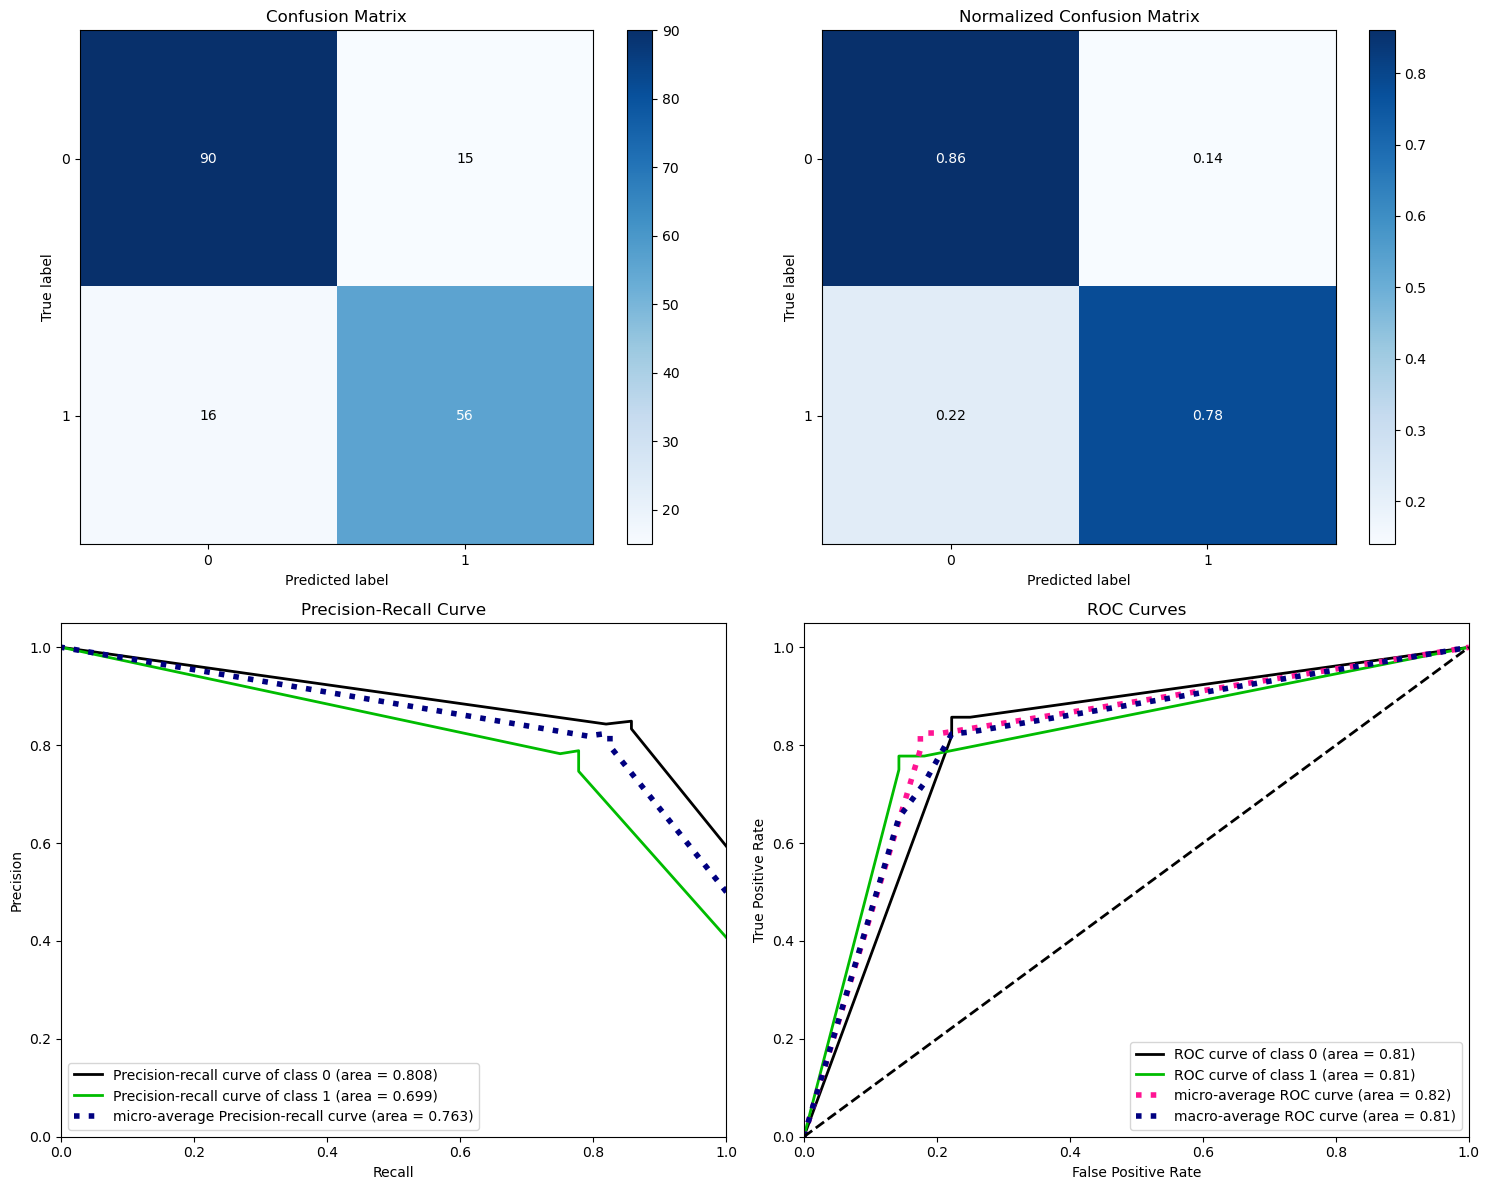

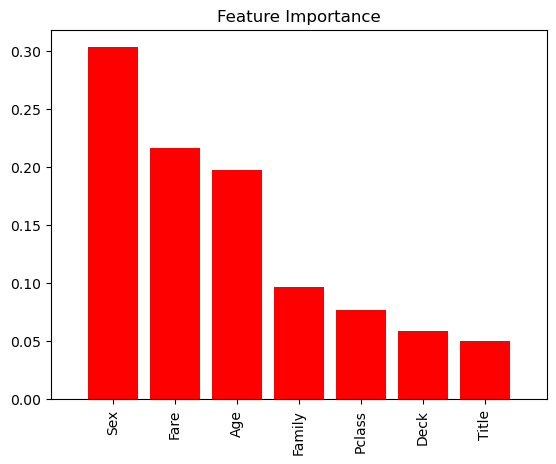


RandomForestClassifier: 
Train score: 0.9829545454545454
Test score: 0.847457627118644
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       105
           1       0.84      0.78      0.81        72

    accuracy                           0.85       177
   macro avg       0.85      0.84      0.84       177
weighted avg       0.85      0.85      0.85       177



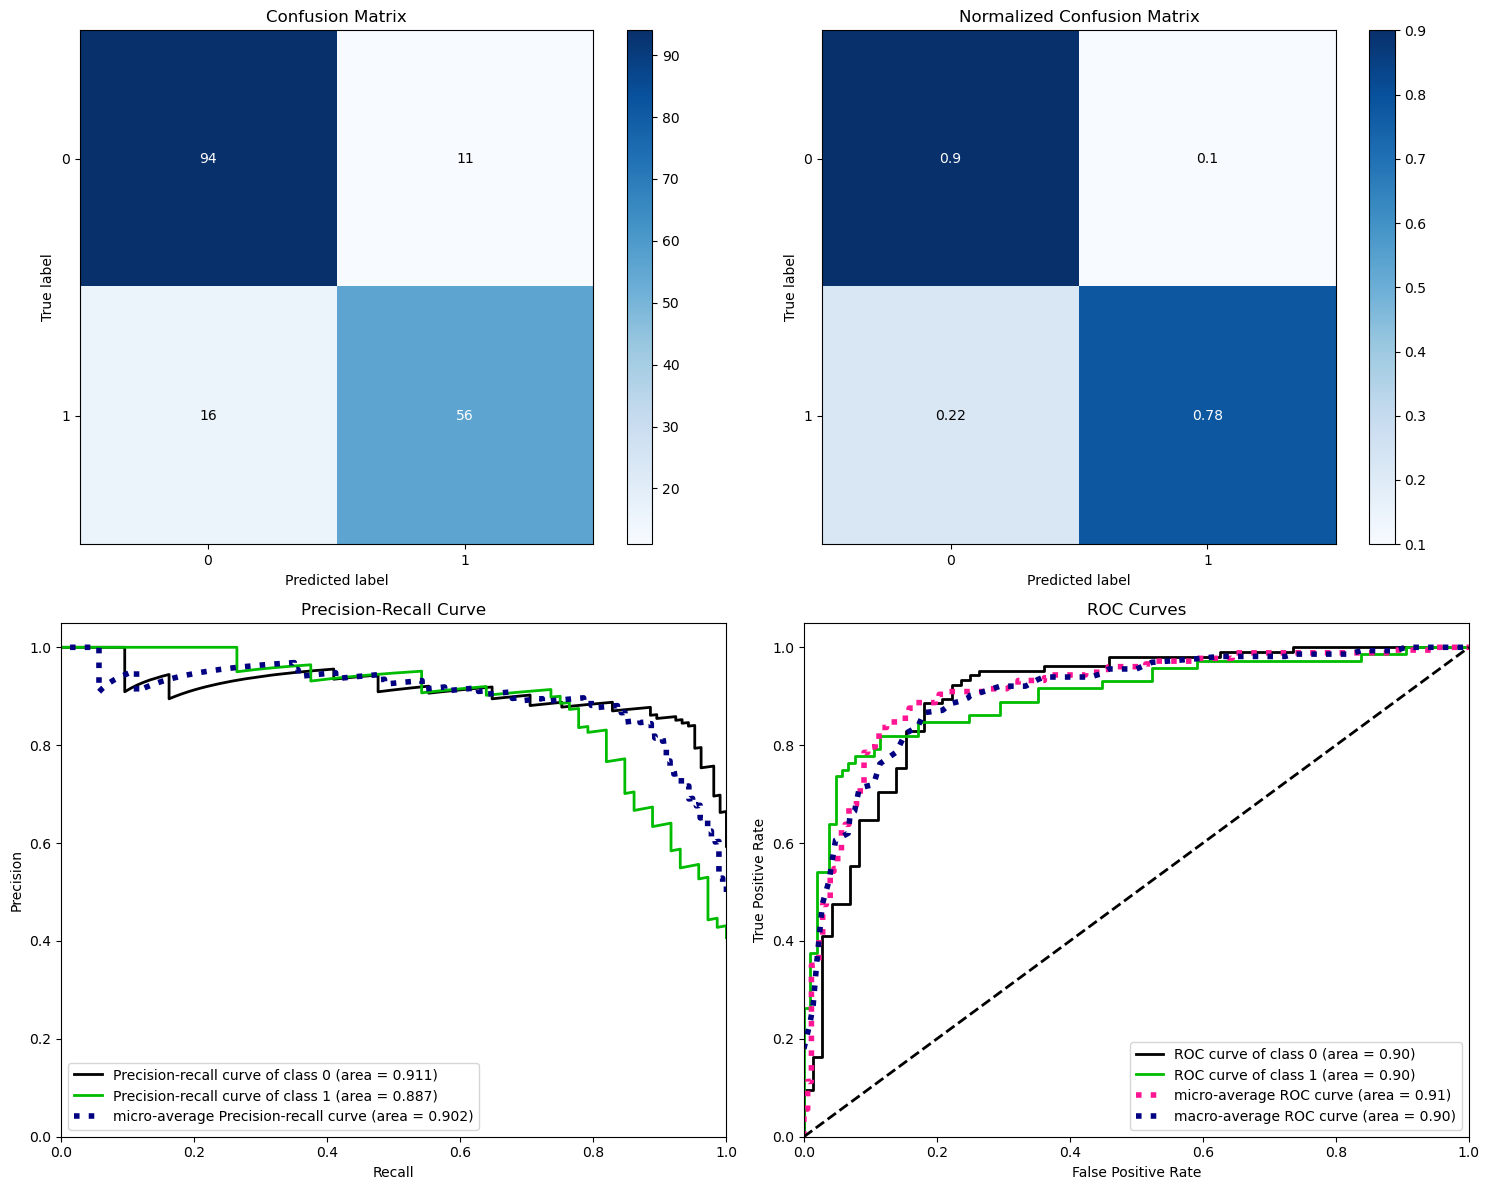

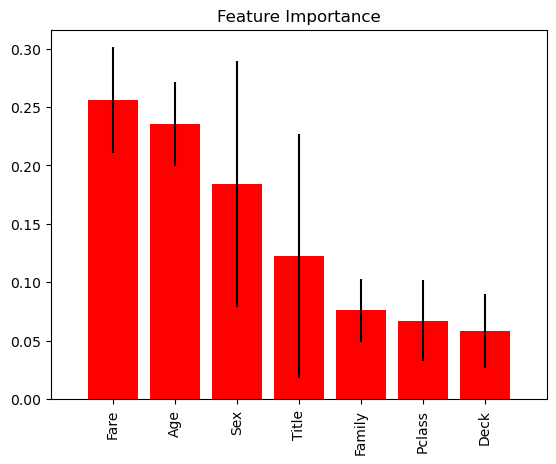


KNeighborsClassifier: 
Train score: 0.8579545454545454
Test score: 0.8192090395480226
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.81      0.72      0.76        72

    accuracy                           0.82       177
   macro avg       0.82      0.80      0.81       177
weighted avg       0.82      0.82      0.82       177

No feature importances function in model

ExtraTreesClassifier: 
Train score: 0.8465909090909091
Test score: 0.8361581920903954
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.83      0.75      0.79        72

    accuracy                           0.84       177
   macro avg       0.84      0.82      0.83       177
weighted avg       0.84      0.84      0.83       177



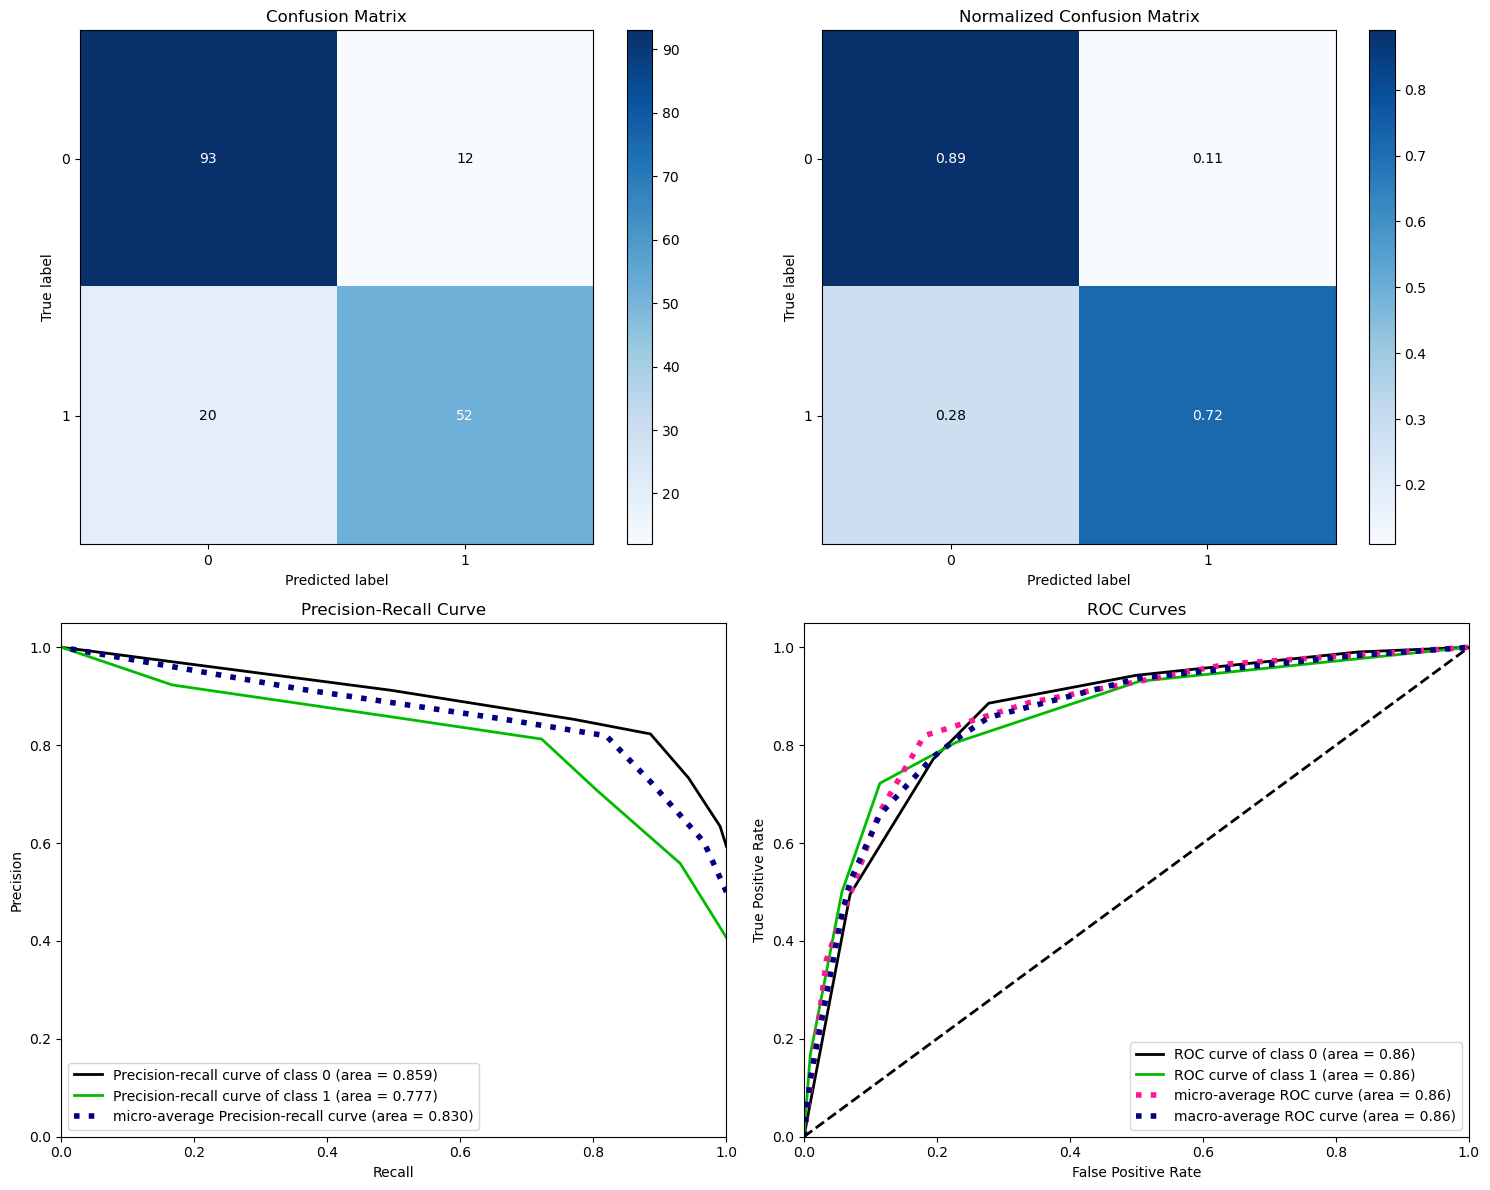

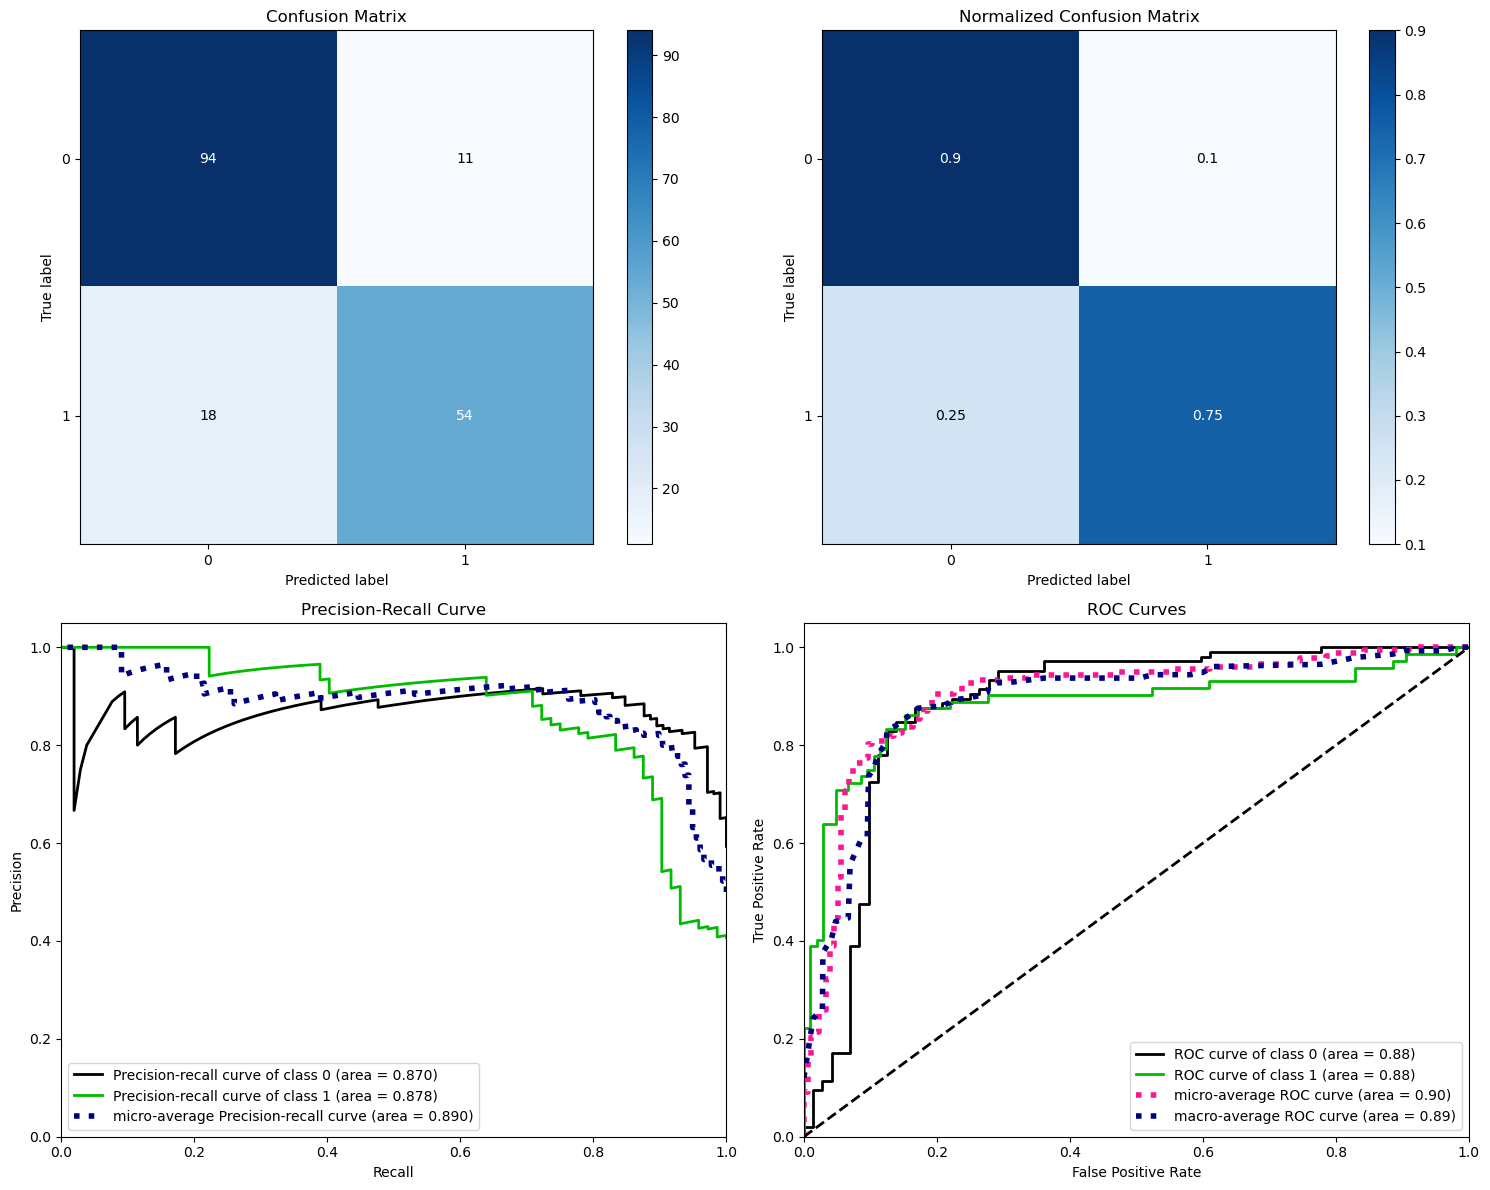

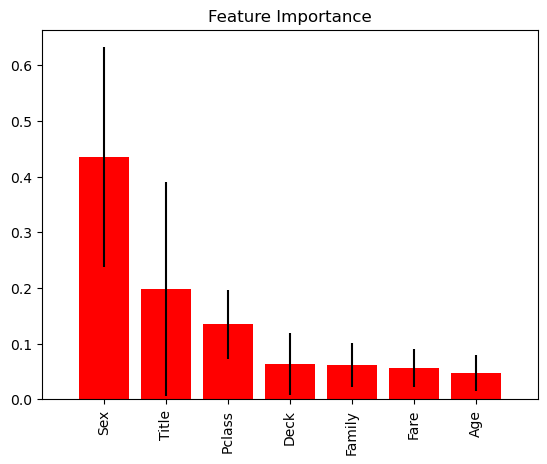


XGBClassifier: 
[15:55:53] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:55:53] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score: 0.9673295454545454
Test score: 0.8361581920903954
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       105
           1       0.81      0.78      0.79        72

    accuracy      

/home/fraz/anaconda3/envs/mlenv/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fraz/anaconda3/envs/mlenv/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


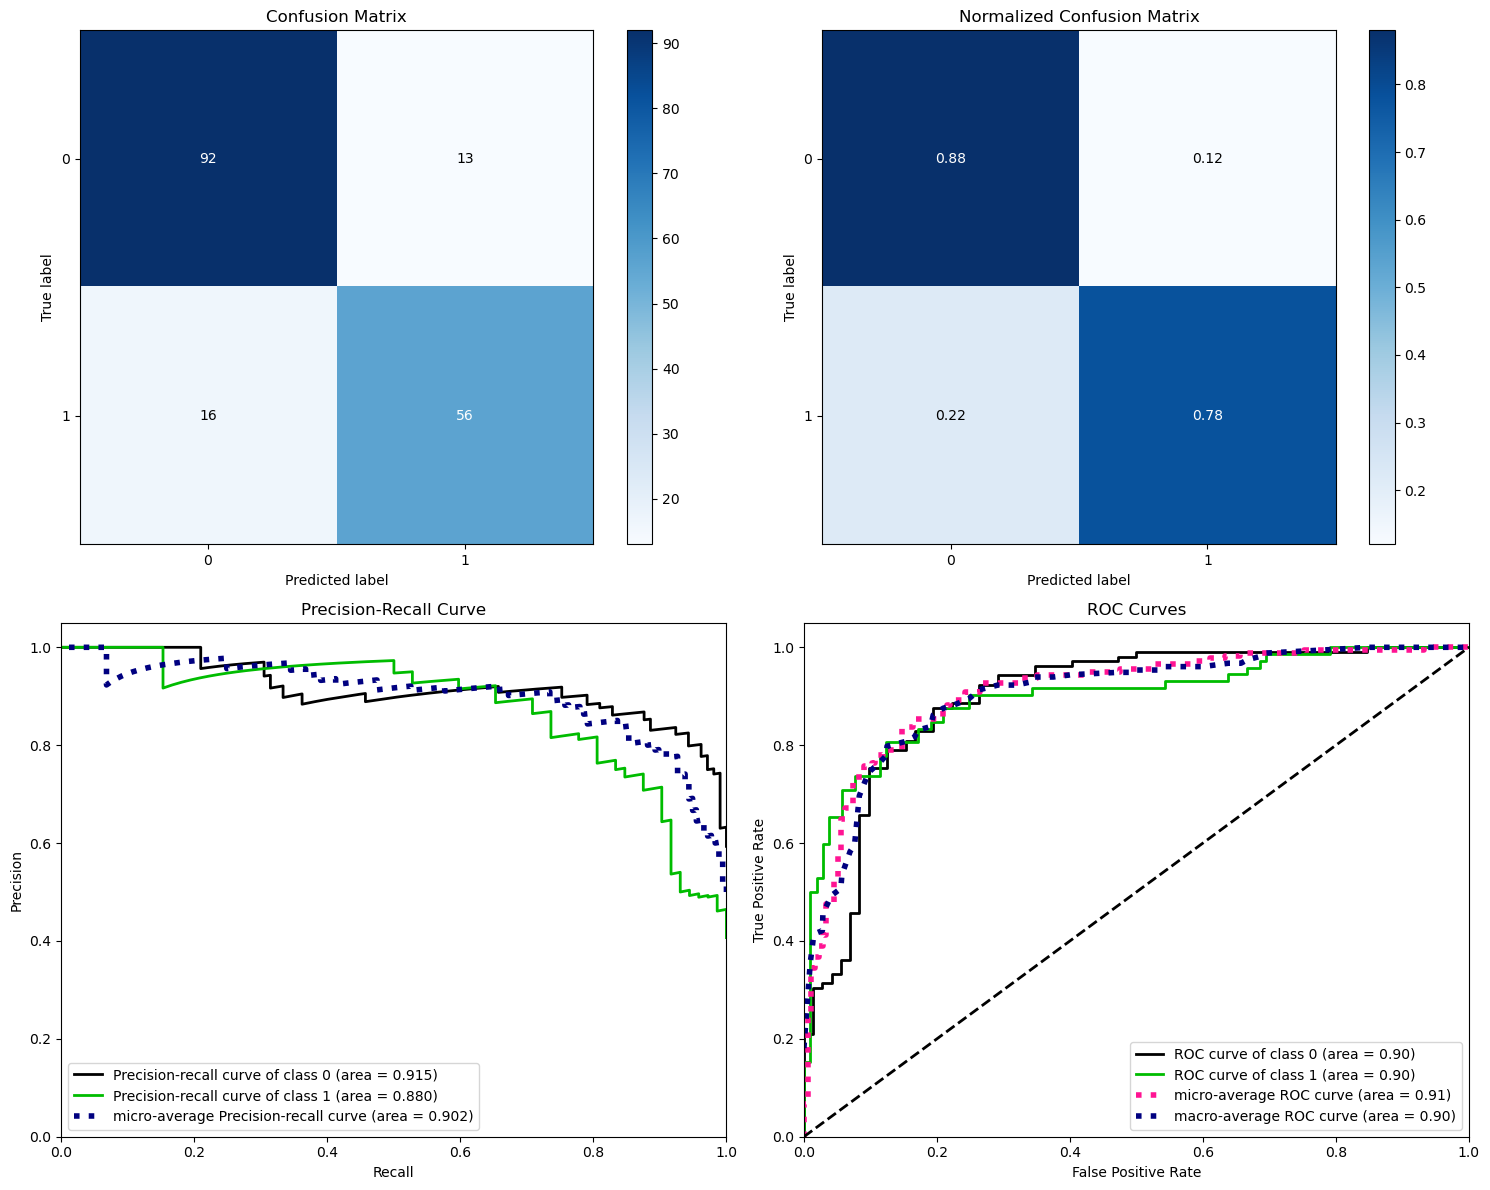

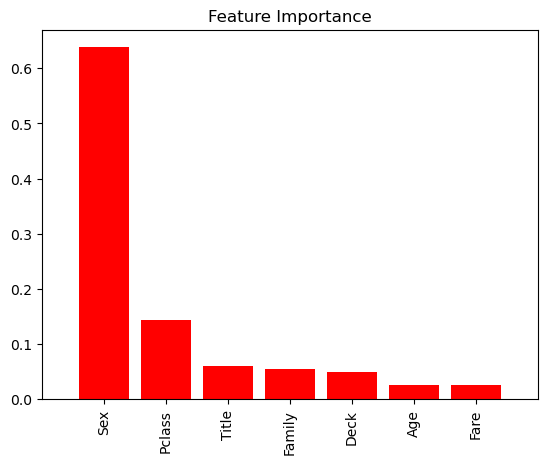


MLPClassifier: 
Train score: 0.8522727272727273
Test score: 0.8587570621468926
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       105
           1       0.86      0.78      0.82        72

    accuracy                           0.86       177
   macro avg       0.86      0.85      0.85       177
weighted avg       0.86      0.86      0.86       177

No feature importances function in model

LogisticRegression: 
Train score: 0.7840909090909091
Test score: 0.807909604519774
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       105
           1       0.76      0.78      0.77        72

    accuracy                           0.81       177
   macro avg       0.80      0.80      0.80       177
weighted avg       0.81      0.81      0.81       177

No feature importances function in model


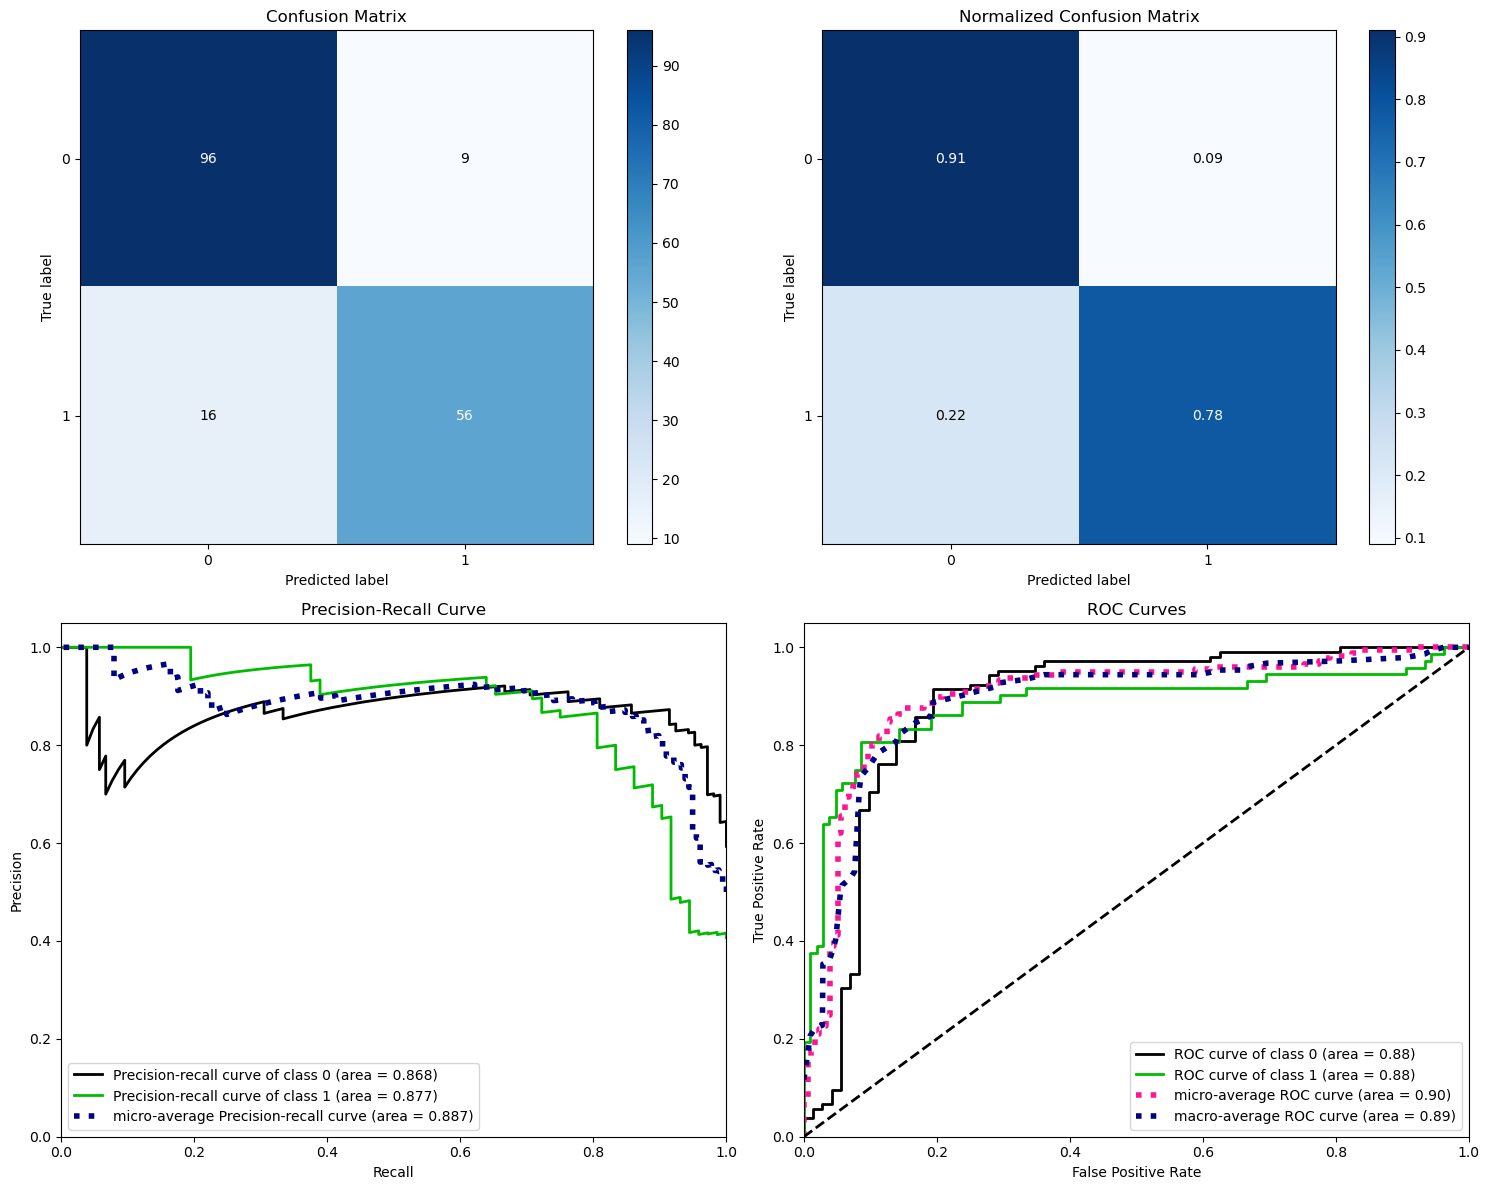

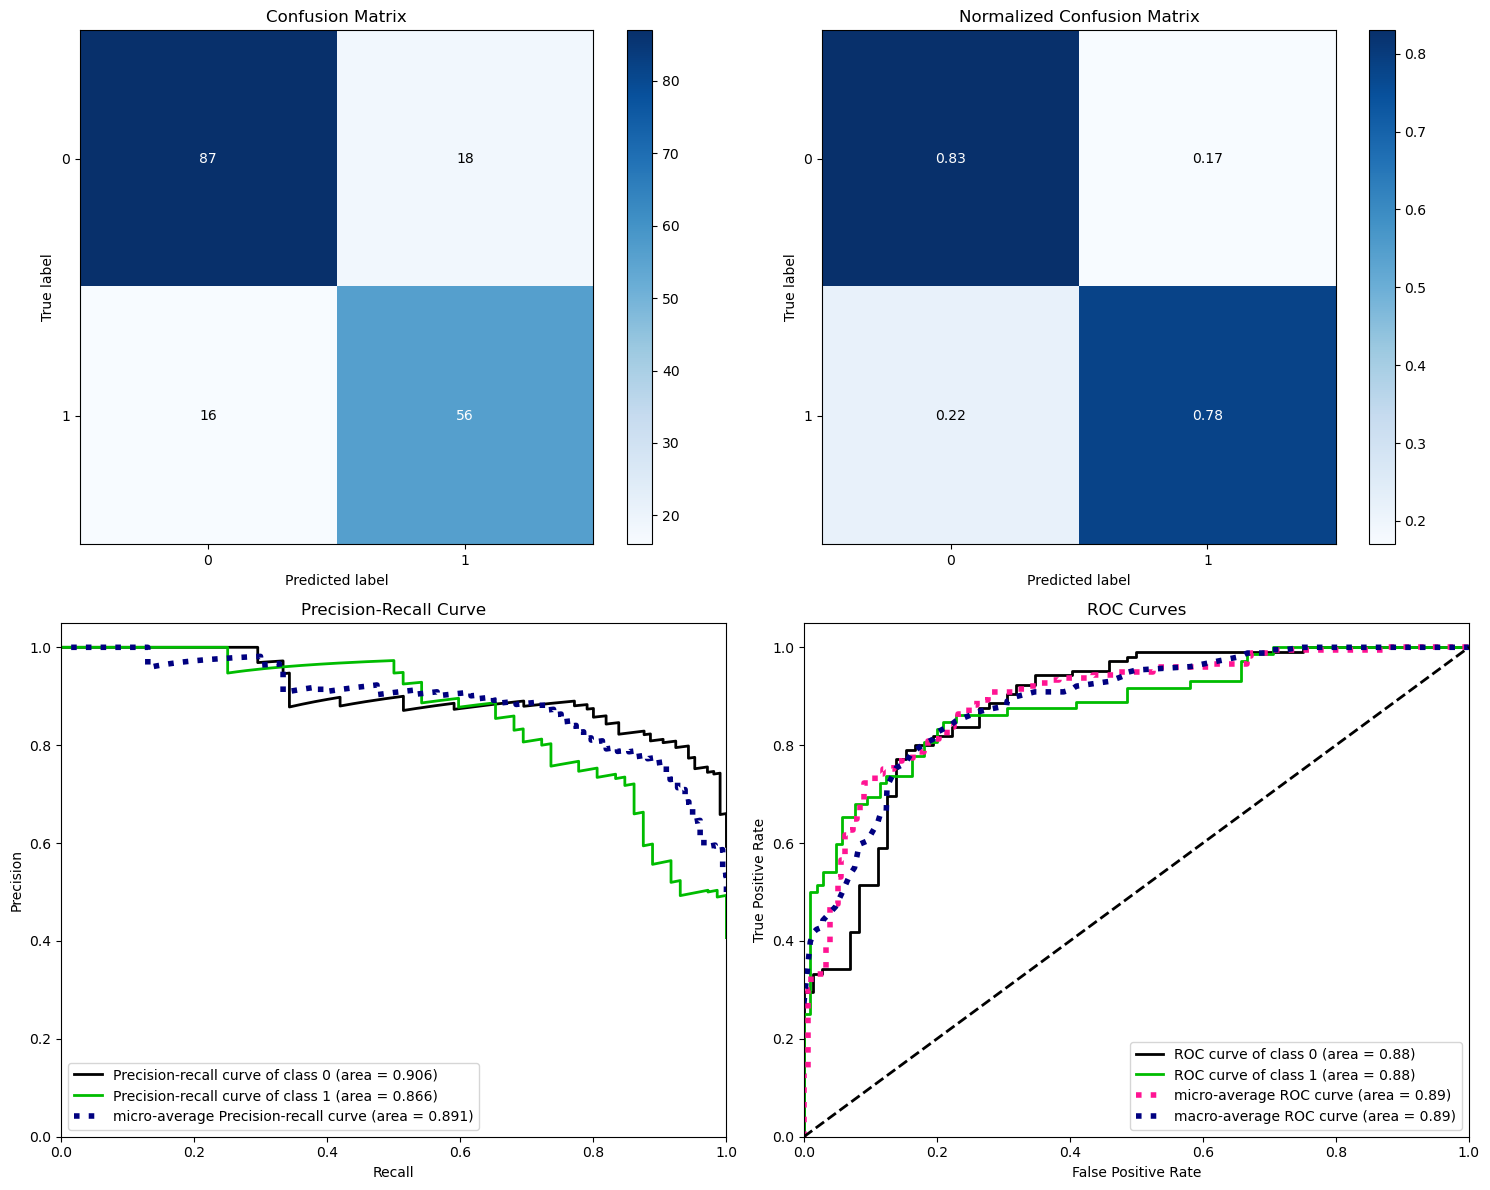

In [34]:
multimodel()

In [35]:
#X, y = sm.fit_resample(X, y)


In [36]:
# Run for CV, go walk the dog.

#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, ShuffleSplit
from imblearn.pipeline import Pipeline, make_pipeline

def kfoldmodel():
    cv = ShuffleSplit(n_splits=20, random_state=0)

    scoresdf = pd.DataFrame(columns = ['model', 'mean score'])

    for name,curr_model in models:
        print()
        print (name)
        pipeline = Pipeline([('scaler', scaler), ('sm', sm), ('model', curr_model)])
        scores = cross_val_score(pipeline, X, y, cv=cv)
        print("scores:", scores)
        meanscore = scores.mean()
        print("Average score: ", meanscore)
        new_row = {'model':name, 'mean score':meanscore}
        scoresdf = pd.concat([scoresdf, pd.DataFrame.from_records([new_row])])
    return scoresdf

kfoldmodel()


CatBoostClassifier: 


NameError: name 'sm' is not defined

In [32]:
#from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X[cols] = scaler.fit_transform(X[cols])
test[cols] = scaler.transform(test[cols])

In [33]:
# Create model from full train set

#odel = CatBoostClassifier(verbose=False, per_float_feature_quantization='1:border_count=1024')
model = ExtraTreesClassifier(min_samples_leaf=1, max_depth=9, n_estimators = 5000)
#odel = MLPClassifier(max_iter=2000)
pipeline = Pipeline([('scaler', scaler), ('model', model)])
pipeline.fit(X, y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 ExtraTreesClassifier(max_depth=9, n_estimators=5000))])

In [36]:
prediction = model.predict(test).astype(int)
prediction

/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [37]:
test

,Pclass,Sex,Age,Fare,Deck,Family,Title
PassengerId,,,,,,,
892,0.0,0.0,0.321429,-0.293071,0.0,0.0,0.0
893,0.0,-1.0,1.214286,-0.329705,0.0,1.0,1.0
894,-1.0,0.0,2.285714,-0.210817,0.0,0.0,0.0
895,0.0,0.0,-0.214286,-0.256091,0.0,0.0,0.0
896,0.0,-1.0,-0.571429,-0.095732,0.0,2.0,1.0
...,...,...,...,...,...,...,...
1305,0.0,0.0,-0.214286,-0.283394,0.0,0.0,0.0
1306,-2.0,-1.0,0.642857,4.176948,-5.0,0.0,-1.0
1307,0.0,0.0,0.607143,-0.318645,0.0,0.0,0.0


In [38]:
output = pd.DataFrame({'PassengerId': test.index, 'Survived': prediction})
output.to_csv('submission.csv', index=False)

In [40]:
#import autosklearn.classification
#automl = autosklearn.classification.AutoSklearnClassifier()
#automl.fit(X_train, y_train)

from autosklearn.experimental.askl2 import AutoSklearn2Classifier
automl = AutoSklearn2Classifier()
automl.fit(X_train, y_train)

OMP: Error #178: Function Can't map SHM failed:
OMP: System error #12: Cannot allocate memory


[ERROR] [2022-05-15 15:47:00,901:Client-AutoML(1):dddbf9b3-d45d-11ec-90b2-0b0c8f1fdbd4] Dummy prediction failed with run state StatusType.CRASHED. The error suggests that the provided memory limits were too tight. Please increase the 'memory_limit' and try again. If this does not solve your problem, please open an issue and paste the additional output. Additional output: {'error': 'Result queue is empty', 'exit_status': "<class 'pynisher.limit_function_call.AnythingException'>", 'subprocess_stdout': '', 'subprocess_stderr': "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py:762: RuntimeWarning: \nFound Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at\nthe same time. Both libraries are known to be incompatible and this\ncan cause random crashes or deadlocks on Linux when loaded in the\nsame Python program.\nUsing threadpoolctl may cause crashes or deadlocks. For more\ninformation and possible workarounds, please see\n    https://github.com/joblib/

ValueError: Dummy prediction failed with run state StatusType.CRASHED. The error suggests that the provided memory limits were too tight. Please increase the 'memory_limit' and try again. If this does not solve your problem, please open an issue and paste the additional output. Additional output: {'error': 'Result queue is empty', 'exit_status': "<class 'pynisher.limit_function_call.AnythingException'>", 'subprocess_stdout': '', 'subprocess_stderr': "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py:762: RuntimeWarning: \nFound Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at\nthe same time. Both libraries are known to be incompatible and this\ncan cause random crashes or deadlocks on Linux when loaded in the\nsame Python program.\nUsing threadpoolctl may cause crashes or deadlocks. For more\ninformation and possible workarounds, please see\n    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md\n\n  warnings.warn(msg, RuntimeWarning)\n", 'exitcode': -6, 'configuration_origin': 'DUMMY'}.

In [ ]:
print('Train score:', automl.score(X_train, y_train))
print('Test score:', automl.score(X_test, y_test))

In [ ]:
 	model 	mean score
0 	CatBoostClassifier: 	0.853333
1 	DecisionTreeClassifier: 	0.804444
2 	RandomForestClassifier: 	0.831852
3 	KNeighborsClassifier: 	0.824444
4 	ExtraTreesClassifier: 	0.816296
5 	XGBClassifier: 	0.834815
6 	MLPClassifier: 	0.814074
7 	LogisticRegression: 	0.817778


	model 	mean score
0 	CatBoostClassifier: 	0.851364
1 	DecisionTreeClassifier: 	0.805455
2 	RandomForestClassifier: 	0.837727
3 	KNeighborsClassifier: 	0.824091
4 	ExtraTreesClassifier: 	0.831364
5 	XGBClassifier: 	0.851364
6 	MLPClassifier: 	0.825
7 	LogisticRegression: 	0.794091

model 	mean score
0 	CatBoostClassifier: 	0.86
1 	DecisionTreeClassifier: 	0.821818
2 	RandomForestClassifier: 	0.847727
3 	KNeighborsClassifier: 	0.816818
4 	ExtraTreesClassifier: 	0.83
5 	XGBClassifier: 	0.849545
6 	MLPClassifier: 	0.833182
7 	LogisticRegression: 	0.805909


model 	mean score
0 	CatBoostClassifier: 	0.855455
1 	DecisionTreeClassifier: 	0.814091
2 	RandomForestClassifier: 	0.847273
3 	KNeighborsClassifier: 	0.846364
4 	ExtraTreesClassifier: 	0.829545
5 	XGBClassifier: 	0.86
6 	MLPClassifier: 	0.847727
7 	LogisticRegression: 	0.805

In [45]:

# -*- encoding: utf-8 -*-
"""
==============
Classification
==============
The following example shows how to fit a simple classification model with
*auto-sklearn*.
"""
from pprint import pprint

import sklearn.datasets
import sklearn.metrics

import autosklearn.classification


############################################################################
# Data Loading
# ============

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, random_state=1)

############################################################################
# Build and fit a classifier
# ==========================

automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_classification_example_tmp2',
)
automl.fit(X_train, y_train, dataset_name='breast_cancer')

############################################################################
# View the models found by auto-sklearn
# =====================================

print(automl.leaderboard())

############################################################################
# Print the final ensemble constructed by auto-sklearn
# ====================================================

pprint(automl.show_models(), indent=4)

###########################################################################
# Get the Score of the final ensemble
# ===================================

predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

OMP: Error #178: Function Can't map SHM failed:
OMP: System error #12: Cannot allocate memory


[ERROR] [2022-05-15 15:59:20,912:Client-AutoML(1):breast_cancer] Dummy prediction failed with run state StatusType.CRASHED. The error suggests that the provided memory limits were too tight. Please increase the 'memory_limit' and try again. If this does not solve your problem, please open an issue and paste the additional output. Additional output: {'error': 'Result queue is empty', 'exit_status': "<class 'pynisher.limit_function_call.AnythingException'>", 'subprocess_stdout': '', 'subprocess_stderr': 'Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f553f14eca0>\nTraceback (most recent call last):\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 584, in match_library_callback\n    self._make_controller_from_path(filepath)\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 725, in _make_cont

ValueError: Dummy prediction failed with run state StatusType.CRASHED. The error suggests that the provided memory limits were too tight. Please increase the 'memory_limit' and try again. If this does not solve your problem, please open an issue and paste the additional output. Additional output: {'error': 'Result queue is empty', 'exit_status': "<class 'pynisher.limit_function_call.AnythingException'>", 'subprocess_stdout': '', 'subprocess_stderr': 'Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f553f14eca0>\nTraceback (most recent call last):\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 584, in match_library_callback\n    self._make_controller_from_path(filepath)\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path\n    lib_controller = lib_controller_class(\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 810, in __init__\n    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/ctypes/__init__.py", line 373, in __init__\n    self._handle = _dlopen(self._name, mode)\nOSError: /home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0: cannot open shared object file: No such file or directory\n/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py:762: RuntimeWarning: \nFound Intel OpenMP (\'libiomp\') and LLVM OpenMP (\'libomp\') loaded at\nthe same time. Both libraries are known to be incompatible and this\ncan cause random crashes or deadlocks on Linux when loaded in the\nsame Python program.\nUsing threadpoolctl may cause crashes or deadlocks. For more\ninformation and possible workarounds, please see\n    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md\n\n  warnings.warn(msg, RuntimeWarning)\n', 'exitcode': -6, 'configuration_origin': 'DUMMY'}.

In [43]:
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(X_train, y_train)
predictions = cls.predict(X_test)

OMP: Error #178: Function Can't map SHM failed:
OMP: System error #12: Cannot allocate memory


[ERROR] [2022-05-15 15:56:32,678:Client-AutoML(1):2cbf78f1-d45f-11ec-90b2-0b0c8f1fdbd4] Dummy prediction failed with run state StatusType.CRASHED. The error suggests that the provided memory limits were too tight. Please increase the 'memory_limit' and try again. If this does not solve your problem, please open an issue and paste the additional output. Additional output: {'error': 'Result queue is empty', 'exit_status': "<class 'pynisher.limit_function_call.AnythingException'>", 'subprocess_stdout': '', 'subprocess_stderr': 'Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f54711d3ee0>\nTraceback (most recent call last):\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 584, in match_library_callback\n    self._make_controller_from_path(filepath)\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", 

ValueError: Dummy prediction failed with run state StatusType.CRASHED. The error suggests that the provided memory limits were too tight. Please increase the 'memory_limit' and try again. If this does not solve your problem, please open an issue and paste the additional output. Additional output: {'error': 'Result queue is empty', 'exit_status': "<class 'pynisher.limit_function_call.AnythingException'>", 'subprocess_stdout': '', 'subprocess_stderr': 'Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f54711d3ee0>\nTraceback (most recent call last):\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 584, in match_library_callback\n    self._make_controller_from_path(filepath)\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path\n    lib_controller = lib_controller_class(\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py", line 810, in __init__\n    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)\n  File "/home/fraz/anaconda3/envs/mlenv/lib/python3.8/ctypes/__init__.py", line 373, in __init__\n    self._handle = _dlopen(self._name, mode)\nOSError: /home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0: cannot open shared object file: No such file or directory\n/home/fraz/anaconda3/envs/mlenv/lib/python3.8/site-packages/threadpoolctl.py:762: RuntimeWarning: \nFound Intel OpenMP (\'libiomp\') and LLVM OpenMP (\'libomp\') loaded at\nthe same time. Both libraries are known to be incompatible and this\ncan cause random crashes or deadlocks on Linux when loaded in the\nsame Python program.\nUsing threadpoolctl may cause crashes or deadlocks. For more\ninformation and possible workarounds, please see\n    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md\n\n  warnings.warn(msg, RuntimeWarning)\n', 'exitcode': -6, 'configuration_origin': 'DUMMY'}.